In [1]:
import tensorflow as tf
from utils import bbox_utils, data_utils, drawing_utils, io_utils, train_utils, eval_utils
from models.decoder import get_decoder_model
from helper import label_generator
from models.ssd_mobilenet_v2 import get_model, init_model
import os
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint
from tqdm import tqdm

In [2]:
TEST_DIR = r"F:\Minor Data Collection\Final Image Data\Monument Original 512\Augmented 512 v2 (PDS included)\All Splitted\TFRecords\test_all_512_v5.tfrecord"
MODEL_PATH = r"C:\Users\parzi\OneDrive - Tribhuvan University\Desktop\Minor Project\Monument Detection with CNN\Monument Object Detection\Trained Models\Trained_Instance_512_all_1\ssd_mobilenet_v2_model_weights.h5"

In [3]:
labels = ['bg', 'badrinath temple', 'basantapur tower', 'bhagavati temple', 'bhairavnath temple', 'bhaktapur tower', 'bhimeleshvara', 'bhimsen temple', 'bhupatindra malla column', 'bhuvana lakshmeshvara', 'chasin dega', 'chayasilin mandap', 'dattatreya temple', 'degu tale temple_KDS', 'fasidega temple', 'gaddi durbar', 'garud', 'golden gate', 'gopinath krishna temple', 'hanuman idol', 'indrapura', 'jagannatha temple', 'kala-bhairava', 'kasthamandap', 'kavindrapura sattal', 'kedamatha tirtha', 'kirtipur tower', 'kumari ghar', 'lalitpur tower', 'mahadev temple', 'narayan temple', 'national gallery', 'nyatapola temple', 'palace of the 55 windows', 'panchamukhi hanuman', 'pratap malla column', 'shiva temple', 'shveta bhairava', 'siddhi lakshmi temple', 'simha sattal', 'taleju bell_BDS', 'taleju bell_KDS', 'taleju temple', 'trailokya mohan', 'vastala temple', 'vishnu temple', 'bhimsen temple_PDS', 'char narayan temple', 'chyasim deval', 'garud statue', 'harishankar temple', 'krishna mandir', 'mani ganesh temple', 'mani mandap', 'royal palace_PDS', 'taleju bell_PDS', 'taleju temple north', 'taleju temple south', 'vishwanath temple', 'yognarendra malla statue']

In [4]:
batch_size = 8
backbone = 'mobilenet_v2'
hyper_params = train_utils.get_hyper_params(backbone, True)
hyper_params["total_labels"] = len(labels)
img_size = hyper_params["img_size"]

image_feature_description = {
    'image/height': tf.io.FixedLenFeature(shape = (), dtype = np.int64),
    'image/width' : tf.io.FixedLenFeature(shape = (), dtype = np.int64),
    'image/filename' : tf.io.FixedLenFeature(shape = (), dtype = tf.string),
    'image/encoded' : tf.io.FixedLenFeature(shape = (), dtype = tf.string),
    'image/object/bbox/xmin': tf.io.FixedLenSequenceFeature(shape = (), dtype = np.float32, allow_missing = True),
    'image/object/bbox/xmax': tf.io.FixedLenSequenceFeature(shape = (), dtype = np.float32, allow_missing = True),
    'image/object/bbox/ymin': tf.io.FixedLenSequenceFeature(shape = (), dtype = np.float32, allow_missing = True),
    'image/object/bbox/ymax': tf.io.FixedLenSequenceFeature(shape = (), dtype = np.float32, allow_missing = True),
    'image/object/class/text':tf.io.FixedLenSequenceFeature(shape = (), dtype = tf.string, allow_missing = True),
    'image/object/class/label':tf.io.FixedLenSequenceFeature(shape = (), dtype = np.int64, allow_missing = True)
}

def _parse_data(unparsed_example):
    return tf.io.parse_single_example(unparsed_example, image_feature_description)

def _bytestring(parsed_example):
    byte_string = parsed_example['image/encoded']
    image = tf.io.decode_image(byte_string)
    image = tf.reshape(image, [512, 512, 3])
    parsed_example['image/encoded'] = image
    bbox = tf.stack([parsed_example['image/object/bbox/ymin'], parsed_example['image/object/bbox/xmin'], parsed_example['image/object/bbox/ymax'], parsed_example['image/object/bbox/xmax']], axis = -1)
    output_dict = {'image': image,
                  'objects': {
                      'bbox': bbox,
                      'label':parsed_example['image/object/class/label']
                  }}

    return output_dict

def get_dataset(path):
    dataset = tf.data.TFRecordDataset(path)
    dataset = dataset.map(_parse_data)
    dataset = dataset.map(_bytestring)
    size_info = dataset.reduce(0, lambda x, _ : x + 1).numpy()
    return dataset, size_info

In [5]:
test_data, size_info = get_dataset(TEST_DIR)
total_items = size_info

data_types = data_utils.get_data_types()
data_shapes = data_utils.get_data_shapes()
padding_values = data_utils.get_padding_values()

test_data = test_data.map(lambda x : data_utils.preprocessing(x, img_size, img_size))
test_data = test_data.padded_batch(batch_size, padded_shapes=data_shapes, padding_values=padding_values)

In [6]:
ssd_model = get_model(hyper_params)
ssd_model.load_weights(MODEL_PATH)
prior_boxes = bbox_utils.generate_prior_boxes(hyper_params["feature_map_shapes"], hyper_params["aspect_ratios"])
ssd_decoder_model = get_decoder_model(ssd_model, prior_boxes, hyper_params)

In [7]:
step_size = train_utils.get_step_size(total_items, batch_size)
pred_bboxes, pred_labels, pred_scores = ssd_decoder_model.predict(test_data, steps=step_size, verbose=1)

295/295 [==============================] - 361s 1s/step


In [8]:
stats = eval_utils.evaluate_predictions(test_data, pred_bboxes, pred_labels, pred_scores, labels, batch_size)
print(stats)

mAP: 0.8181534553179381
{1: {'label': 'badrinath temple', 'total': 61, 'tp': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'fp': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'scores': [0.7791881, 0.9998497, 0.9999274, 0.99977094, 0.9994869, 0.9999453, 0.999846, 0.99973184, 0.99618536, 0.9989937, 0.9994723, 0.99465215, 0.9989637, 0.99814796, 0.9930743, 0.99268335, 0.9928214, 0.9919303, 0.99329996, 0.99326694, 0.9744377, 0.99094427, 0.7859814, 0.9475508, 0.9932053, 0.99590576, 0.9952114, 0.9955421, 0.99601483, 0.988352, 0.99673504, 0.998589, 0.93942493, 0.9992551, 0.9991091, 0.9977494, 0.9991339, 0.9966371, 0.99984515, 0.9999888, 0.9999765, 0.9999763, 0.99992526, 0.99981827, 0.99990106, 0.9999274, 0.99642247, 0.9716655, 0.99919635, 0.991

### Plot Average Precision plot

In [42]:
metric_list = list()
for label, info_dict in stats.items():
    tp = info_dict['tp'].count(1)
    fp = info_dict['fp'].count(1)
    total = info_dict['total']
    
    pr = tp / (tp + fp)
    rc = tp / total
    
    f1_score = 2 * ((pr * rc) / (pr + rc))
    mn_name = info_dict['label']
    metric_list.append((mn_name, round(pr, 4) * 100, round(rc, 3) * 100, round(f1_score, 4) * 100, round(info_dict['AP'], 4) * 100))
metric_df = pd.DataFrame(metric_list, columns = ['Monument Class', 'Precision', 'Recall', 'F1 score', 'Average Precision (AP)'])

In [ ]:
metric_df.reset_index(drop = True)

metric_df
# metric_df.to_excel('./Curves and Graphs/performance_metrics.xlsx')

In [63]:
new_df = pd.read_excel('./Curves and Graphs/performance_metrics.xlsx')
new_df['Average Precision (%)'].mean()

78.47118644067795

In [51]:
test_data, size_info = get_dataset(TEST_DIR)
test_data = test_data.map(lambda x : data_utils.preprocessing(x, img_size, img_size))

In [53]:
ap_list = list()
for label, info_dict in stats.items():
    ap_list.append((label, info_dict['AP']))

In [84]:
for ind, val in ap_list:
    if val > 0.909:
        print(ind, stats[ind]['label'])
ap_list

7 bhimsen temple
9 bhuvana lakshmeshvara
14 fasidega temple
19 hanuman idol
24 kavindrapura sattal
43 trailokya mohan


[(1, 0.9059011164274323),
 (2, 0.9038208168642953),
 (3, 0.9074380165289256),
 (4, 0.9034965034965036),
 (5, 0.9006734006734007),
 (6, 0.9025974025974026),
 (7, 0.9090909090909091),
 (8, 0.3460410557184751),
 (9, 0.9090909090909091),
 (10, 0.897038567493113),
 (11, 0.7880136307459911),
 (12, 0.8973382881658055),
 (13, 0.8990378392371748),
 (14, 0.9090909090909091),
 (15, 0.8933737628813385),
 (16, 0.8181818181818182),
 (17, 0.8149920255183414),
 (18, 0.790352845683728),
 (19, 0.9090909090909091),
 (20, 0.8181818181818182),
 (21, 0.7900955039112934),
 (22, 0.8816627816627818),
 (23, 0.8943488943488944),
 (24, 1.0),
 (25, 0.9076246334310851),
 (26, 0.9076246334310851),
 (27, 0.895878711452482),
 (28, 0.7993075720348447),
 (29, 0.9076479076479077),
 (30, 0.806789984209339),
 (31, 0.9012955643390425),
 (32, 0.7014480631501908),
 (33, 0.8149920255183414),
 (34, 0.8181818181818182),
 (35, 0.6064325251631755),
 (36, 0.9077340569877883),
 (37, 0.9074380165289256),
 (38, 0.6829583460018244),
 (

In [68]:
ap_values = [x for _, x in ap_list]
max_ap_index = ap_values.index(max(ap_values))
maxm_ap_mn_class = labels[max_ap_index + 1]

min_ap_index = ap_values.index(min(ap_values))
min_ap_mn_class = labels[min_ap_index + 1]

In [70]:
len(stats[max_ap_index + 1]['recall'])

75

In [102]:
trailokya_mohan = tuple(zip(stats[43]['precision'], stats[43]['recall']))

In [103]:
df = pd.DataFrame(trailokya_mohan, columns = ['precision', 'recall'])
df.to_csv('./Curves and Graphs/trailokya_mohan.csv')

In [98]:
stats[4]['recall']

75


In [6]:
new_df = pd.read_csv('./Curves and Graphs/trailokya_mohan.csv')

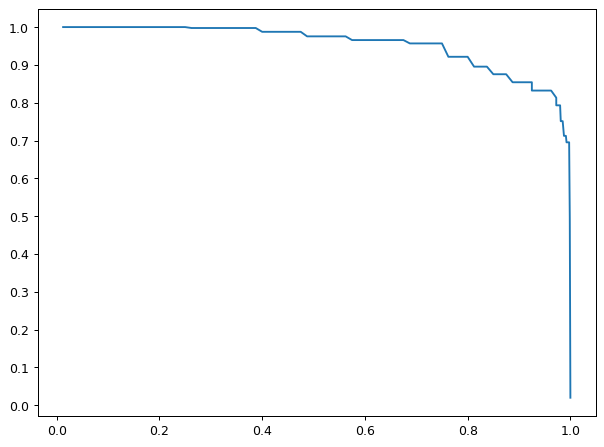

In [7]:
plt.figure(figsize = (8, 6), dpi = 90)
# plt.style.use('seaborn-whitegrid')
plt.style.use('default')
plt.plot(new_df['recall'], new_df['precision'])
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.show()

In [8]:
calculate_AP(new_df)

0.8780472272727273

### For Bhupatindra Malla Column

In [9]:
# bhupatindra_malla = tuple(zip(stats[8]['precision'], stats[8]['recall']))
# df = pd.DataFrame(bhupatindra_malla, columnas = ['precision', 'recall'])
# df.to_csv('./Curves and Graphs/bhupatindra_malla.csv')

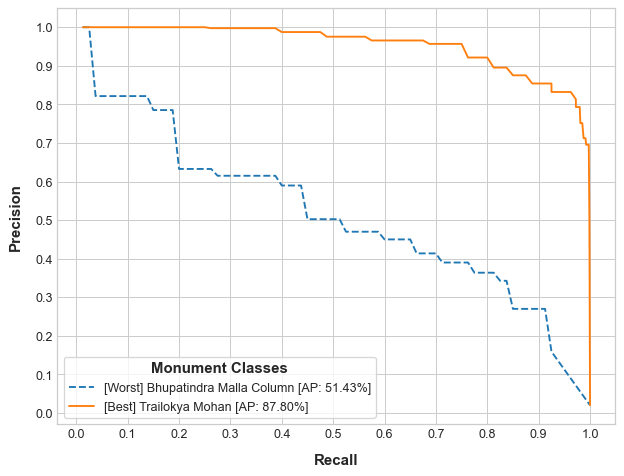

In [13]:
new_x_df = pd.read_csv('./Curves and Graphs/bhupatindra_malla.csv')

font_title = {'size':14, 'weight':'bold'}
font_label = {'size':12, 'weight':'bold'}

plt.figure(figsize = (8, 6), dpi = 90)
plt.style.use('seaborn-whitegrid')
# plt.style.use('default')

plt.plot(new_x_df['recall'], new_x_df['precision'],  '--',  label = f'[Worst] Bhupatindra Malla Column [AP: {calculate_AP(new_x_df) * 100:.2f}%]')
plt.plot(new_df['recall'], new_df['precision'], label = f'[Best] Trailokya Mohan [AP: {calculate_AP(new_df) * 100:.2f}%]' )
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.xlabel('Recall', fontdict = font_label, labelpad = 10.0)
plt.ylabel('Precision', fontdict = font_label, labelpad = 10.0)
# plt.title('Precision x Recall Curve (Best and Worst case)', fontdict = font_title)
plt.legend(loc = 'best', title = 'Monument Classes', frameon = True, title_fontproperties = {'size': 12, 'weight': 'bold'})
plt.savefig(r'C:\Users\parzi\OneDrive - Tribhuvan University\Desktop\Minor Project\Results and Analysis\Offline Model\Fixes-PR curve.png', dpi = 160, bbox_inches = 'tight', pad_inches = 0.2)
plt.show()

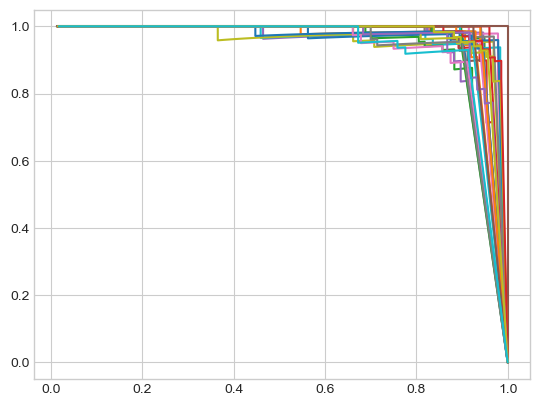

In [376]:
count = 0
# plt.figure(figsize = (10, 8), dpi = 160)
for index, mn_info in stats.items():
    if mn_info['AP'] > 0.89:
        recall_list = mn_info['recall'].tolist()
        precision_list = mn_info['precision'].tolist()
        count += 1
        recall_list.append(1.0)
        precision_list.append(0.0)
        mn_class = tuple(zip(precision_list, recall_list))
        df = pd.DataFrame(mn_class, columns = ['precision', 'recall'])
        df.to_csv(f"./Curves and Graphs/PR-Curve/{mn_info['label']}.csv")
        plt.plot(recall_list, precision_list)
plt.show()

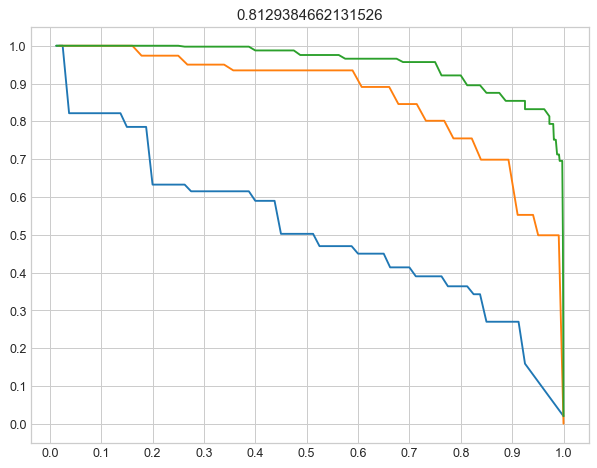

In [457]:
monument_name = "vishnu temple"

new_x_df = pd.read_csv('./Curves and Graphs/bhupatindra_malla.csv')
test_df = pd.read_csv(f'./Curves and Graphs/PR-Curve/{monument_name}.csv')

font_title = {'size':14, 'weight':'bold'}
font_label = {'size':12, 'weight':'bold'}

plt.figure(figsize = (8, 6), dpi = 90)
plt.style.use('seaborn-whitegrid')
# plt.style.use('default')

plt.plot(new_x_df['recall'], new_x_df['precision'],  label = f'Bhupatindra Malla Column [AP: {calculate_AP(new_x_df) * 100:.2f}%]')

plt.plot(test_df['recall'], test_df['precision'])
plt.plot(new_df['recall'], new_df['precision'], label = f'Trailokya Mohan [AP: {calculate_AP(new_df) * 100:.2f}%]' )
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.xticks(np.arange(0.0, 1.1, 0.1))

plt.title(calculate_AP(test_df))
plt.show()

In [4]:
def calculate_AP(new_df):
    import math
    def calculate_p(rv, hp, lp, hr, lr):
        value = lp + ((hp-lp)/(hr-lr)) * (rv - lr)
        if math.isinf(value):
            return lp
        else:
            return value
    eleven_point = np.arange(0.0, 1.1, 0.1).tolist()
    total_len = len(eleven_point)
    list_size = len(list(new_df['precision'].to_numpy()))
    rc = list(new_df['recall'].to_numpy())
    pr = list(new_df['precision'].to_numpy())
    points_precision_val = list()
    
    for interpolation_point in eleven_point:
        for val_index in range(list_size):
            if rc[val_index] > interpolation_point:
                if val_index == 0:
                    points_precision_val.append(pr[val_index])
                    break
                else:
                    recall_value = interpolation_point
                    high_p = pr[val_index]
                    low_p = pr[val_index - 1]
                    high_r = rc[val_index]
                    low_r = rc[val_index - 1]
                    points_precision_val.append(calculate_p(recall_value, high_p, low_p, high_r, low_r))
                    break
    return np.sum(np.array(points_precision_val)) / total_len

In [219]:
calculate_AP(new_df)

0.8411873636363637

### Plot all the PR-Curve

In [458]:
BASE_DIR = r"C:\Users\parzi\OneDrive - Tribhuvan University\Desktop\Minor Project\Monument Detection with CNN\Monument Object Detection\Curves and Graphs\PR-Curve"

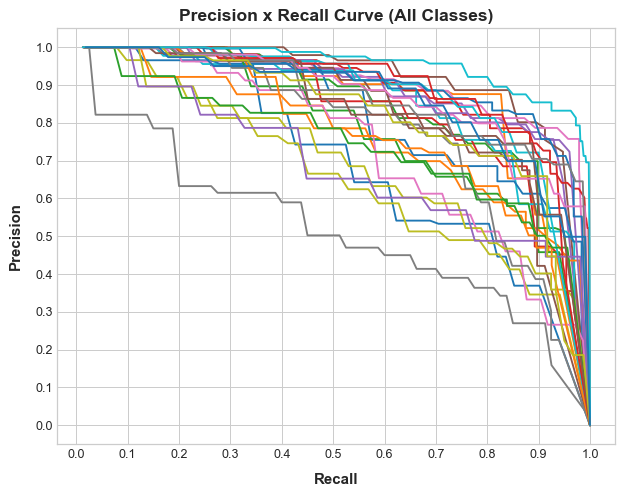

In [463]:
plt.figure(figsize = (8, 6), dpi = 90)
plt.style.use('seaborn-whitegrid')
for csv_file in os.listdir(BASE_DIR):
    csv_df = pd.read_csv(os.path.join(BASE_DIR, csv_file))
    plt.plot(csv_df['recall'], csv_df['precision'])
    plt.yticks(np.arange(0.0, 1.1, 0.1))
    plt.xticks(np.arange(0.0, 1.1, 0.1))

    plt.xlabel('Recall', fontdict = font_label, labelpad = 10.0)
    plt.ylabel('Precision', fontdict = font_label, labelpad = 10.0)
    plt.title('Precision x Recall Curve (All Classes)', fontdict = font_title)
    plt.savefig('./Curves and Graphs/offline-trained-PR curve-all-classes.png', dpi = 160, bbox_inches = 'tight', pad_inches = 0.2)

plt.show()

## Trying to plot accumulated PR-curve for all the classes (failed)

In [22]:
def IOU_score(pred_bbox, gt_bbox, width = 512, height = 512):
    p_y1, p_x1, p_y2, p_x2 = pred_bbox
    gt_y1, gt_x1, gt_y2, gt_x2 = gt_bbox

    p_y1, p_x1, p_y2, p_x2 = int(p_y1 * height), int(p_x1 * width), int(p_y2 * height), int(p_x2 * width)
    gt_y1, gt_x1, gt_y2, gt_x2 = int(gt_y1 * height), int(gt_x1 * width), int(gt_y2 * height), int(gt_x2 * width)
    
    area_pbox = (p_x2 - p_x1) * (p_y2 - p_y1)
    area_gtbox = (gt_x2 - gt_x1) * (gt_y2 - gt_y1)

    xx = max(p_x1, gt_x1)
    yy = max(p_y1, gt_y1)
    aa = min(p_x2, gt_x2)
    bb = min(p_y2, gt_y2)

    w = max(0, aa - xx)
    h = max(0, bb - yy)

    intersection_area = w * h

    if intersection_area == 0:
        return 0
    union_area = area_pbox + area_gtbox - intersection_area
    return float(intersection_area) / float(union_area)

In [44]:
precision_list = []
recall_list = []
def PR_Curve():
    iou_threshold = 0.5
    image_no = 0
    data_list = []
    accumulated_TP = 0
    accumulated_FP = 0
    gt_ROIs = 0
    for index, ele in tqdm(enumerate(test_data)):
        gt_ind_ROI = 0
        image_name = 'Image ' + str(image_no)

        bounding_boxes = ele[1].numpy()
        class_labels = ele[2].numpy()

        predicted_pred_bboxes = pred_bboxes[index]
        pred_class_labels = pred_labels[index]
        pred_conf_scores = pred_scores[index]

        for _ in class_labels:
            gt_ind_ROI += 1
        gt_ROIs += gt_ind_ROI

        detected_count = 0
    
        # detection boxes in the predictions
        for bbox in predicted_pred_bboxes:
            if bbox[0] > 0 or bbox[1] > 0 or bbox[2] > 0 or bbox[3] > 0:
                detected_count += 1
            else:
                break
                
        for i in range(detected_count):
            tp = 0
            fp = 0
            tn = 0
            fn = 0
            
            curr_pred_bbox = predicted_pred_bboxes[i]
            curr_pred_label = pred_class_labels[i]
            
            for j, bbox in enumerate(bounding_boxes):
                iou_score = IOU_score(curr_pred_bbox, bbox)
                if iou_score >= iou_threshold:
                    if curr_pred_label == class_labels[j]:
                        tp += 1
                    else:
                        fp += 1
                    break
                elif iou_score < iou_threshold:
                    fp += 1

                if curr_pred_label != class_labels[j]:
                    if class_labels[j] in pred_class_labels:
                        predicted_class_index = pred_class_labels.tolist().index(class_labels[j])
                        iou_score = IOU_score(bbox, predicted_pred_bboxes[predicted_class_index])
                        if iou_score > iou_threshold:
                            if class_labels[j] == pred_class_labels[predicted_class_index]:
                                tn += 1
                            else:
                                fn += 1
                            break
                        elif iou_score < iou_threshold:
                            fn += 1
                            
            data_list.append((image_name, labels[int(pred_class_labels[i])], pred_conf_scores[i] * 100, tp, fp, detected_count))

        image_no += 1

    column_name = ['Image', 'Detections', 'Confidence %', "TP", "FP", 'detected_count']
    df = pd.DataFrame(data_list, columns = column_name)

    df.sort_values(['Confidence %'], inplace = True, ignore_index=True, ascending = False)

    sorted_list = list()
    accumulated_TP = 0
    accumulated_FP = 0

    for row in df.iterrows():
        accumulated_TP += row[1]['TP'] 
        accumulated_FP += row[1]['FP'] + 3
        
        precision = float(accumulated_TP) / (float(accumulated_TP) + float(accumulated_FP))
        recall = float(accumulated_TP) / gt_ROIs
        
        sorted_list.append((row[1]['Image'], row[1]['Detections'], row[1]['Confidence %'], row[1]['TP'], row[1]['FP'], accumulated_TP, accumulated_FP, precision, recall))

    column_name = ['Image', 'Detections', 'Confidence %', "TP", "FP", 'Acc TP', 'Acc FP', 'Precision', 'Recall']
    sorted_df = pd.DataFrame(sorted_list, columns = column_name)

    precision_list.append(sorted_df['Precision'])
    recall_list.append(sorted_df['Recall'])

In [45]:
PR_Curve()

2357it [00:06, 374.60it/s]


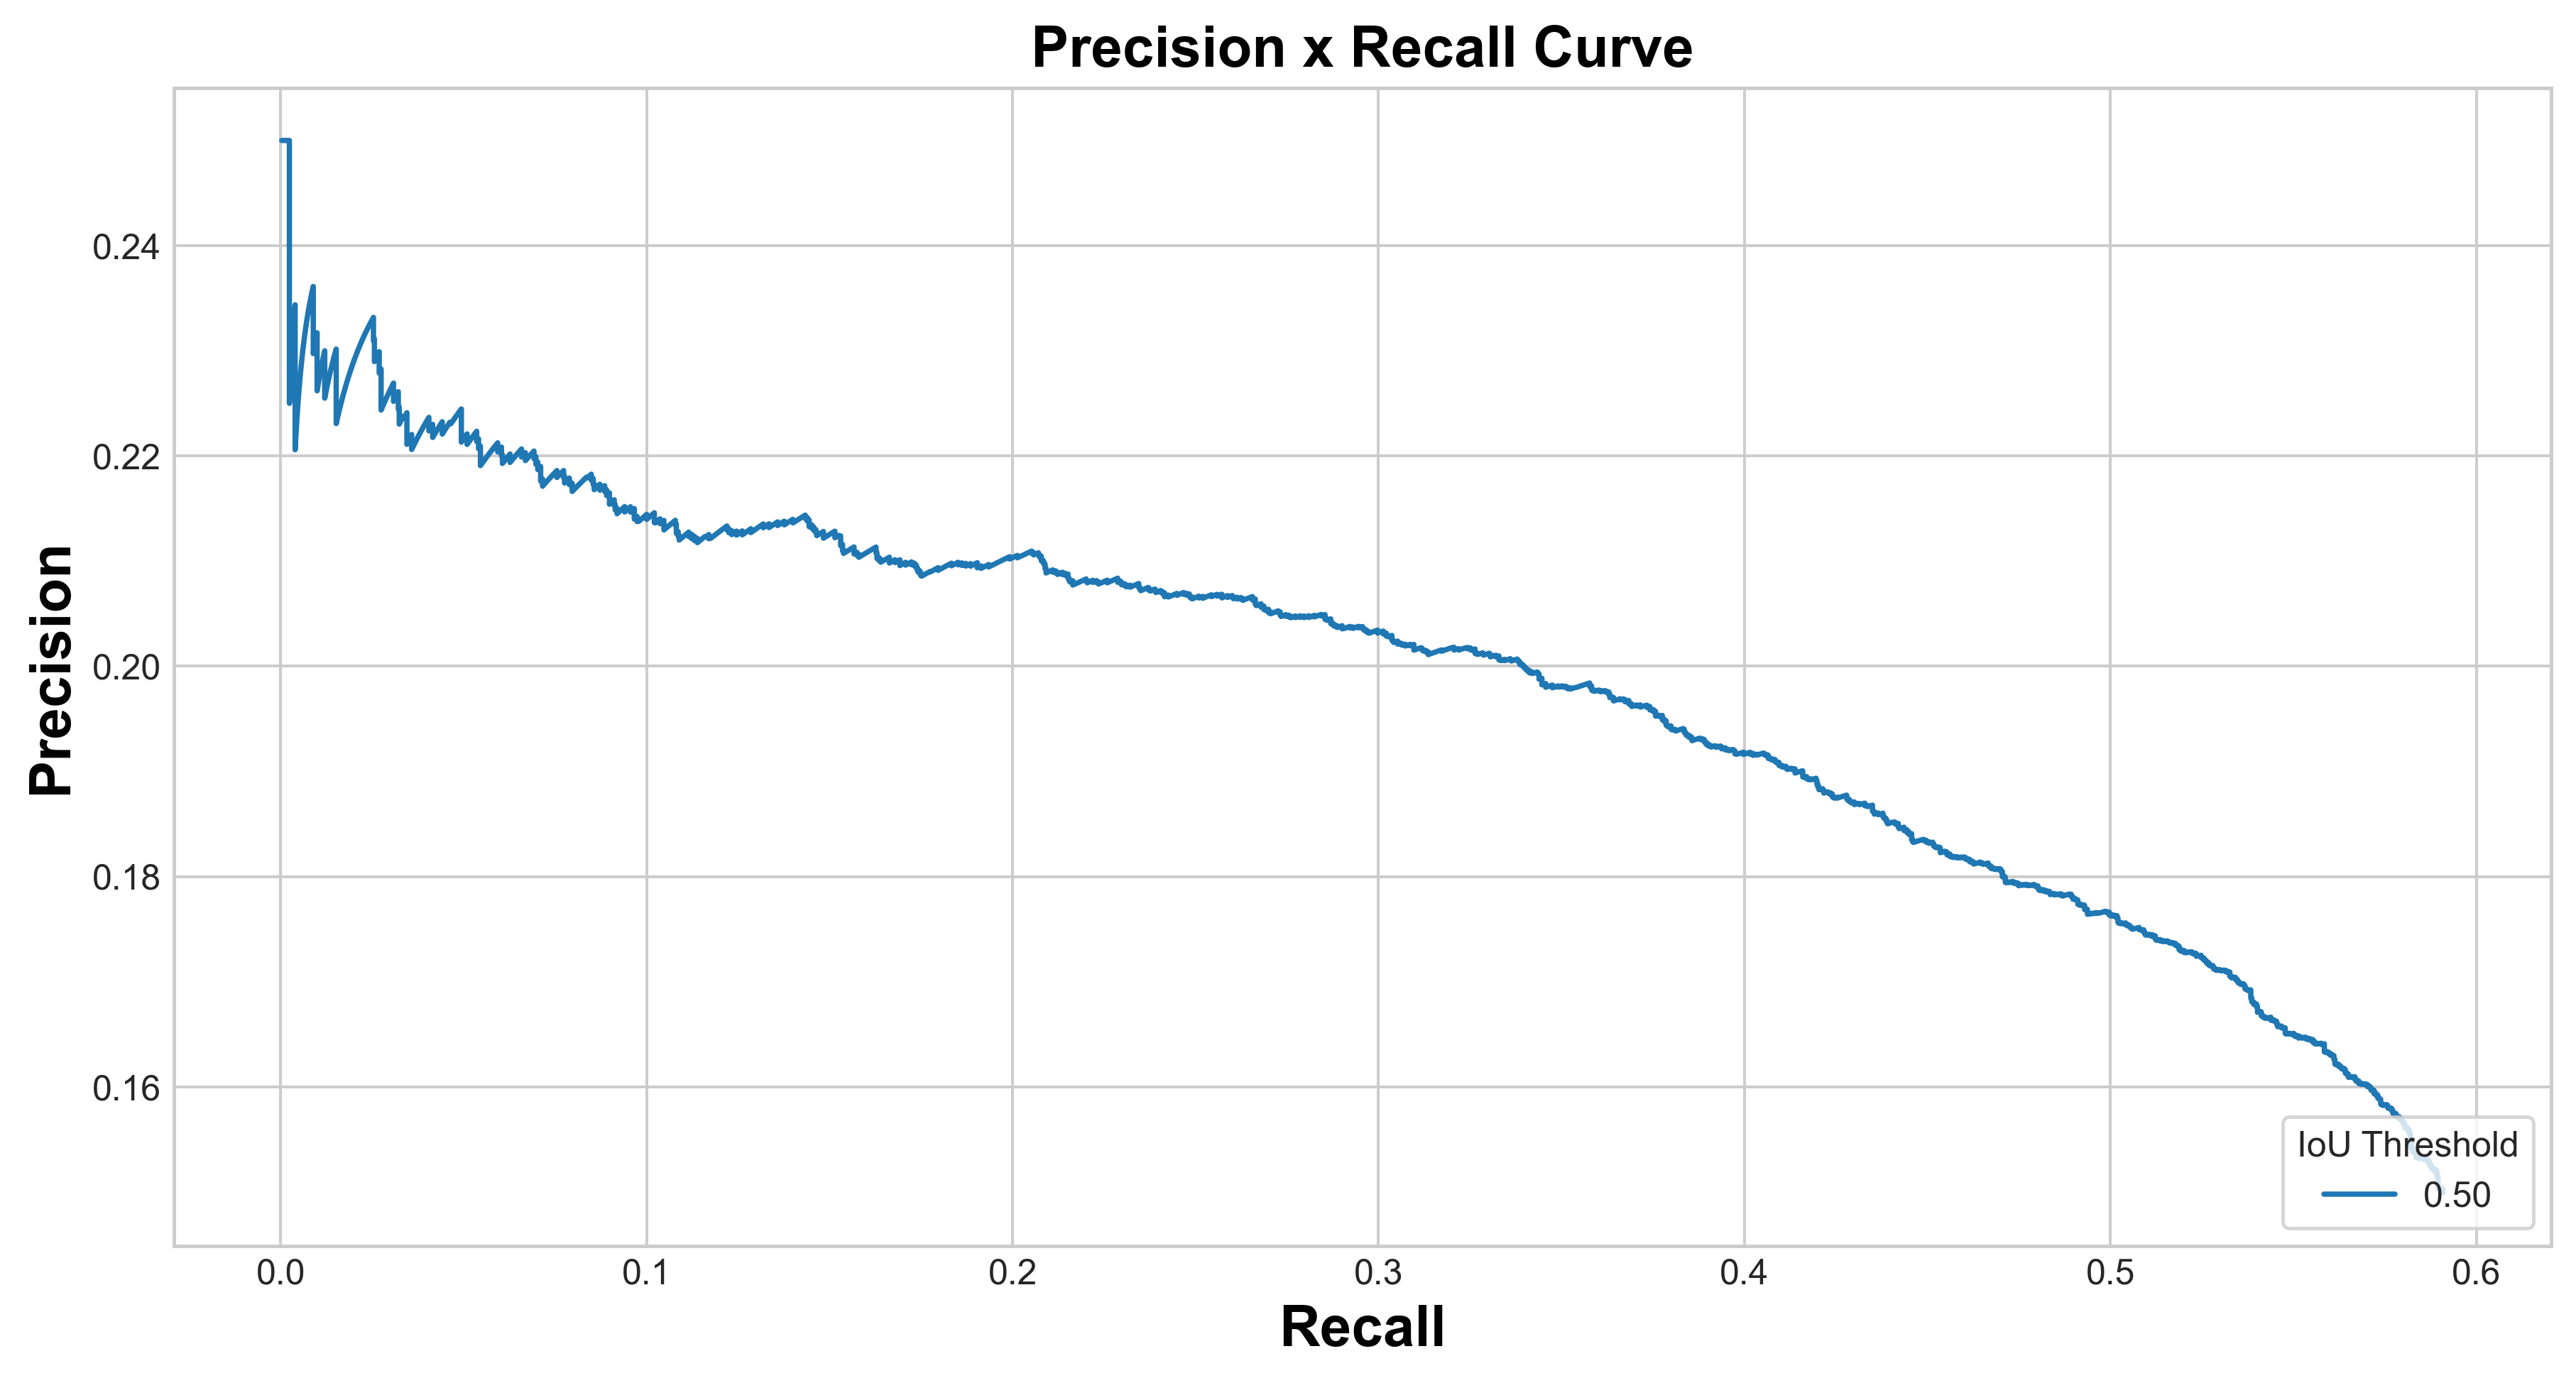

In [47]:
plt.figure(figsize = (12, 6), dpi = 360)
plt.style.use('seaborn-whitegrid')
font = {'color': 'black', 'size': 16, 'weight': 'bold'}
threshold_range = np.arange(0.5, 0.96, 0.05)

for i in range(len(precision_list)):
    plt.plot(recall_list[i], precision_list[i], label = "%.2f" % threshold_range[i])
    plt.xlabel('Recall', fontdict = font)
    plt.ylabel('Precision', fontdict = font)
    plt.title(f'Precision x Recall Curve', font)
plt.legend(loc = 'lower right', title = 'IoU Threshold', frameon = True)
# plt.xticks(np.arange(0, 0.9, 0.05))
# plt.yticks(np.arange(0, 1.1, 0.1))
# plt.savefig("Precision x Recall Curve-0.5 to 0.95.jpg", dpi = 360, bbox_inches = 'tight', pad_inches = 0.3)
plt.show()